In [1]:
!gdown '1dtSfWoas01RlBcoXvdt7LDGT4MgfBNxq'

Downloading...
From: https://drive.google.com/uc?id=1dtSfWoas01RlBcoXvdt7LDGT4MgfBNxq
To: /content/dataset.zip
100% 369M/369M [00:06<00:00, 60.4MB/s]


### 设置超参数

In [2]:
IMG_SIZE = 625
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

### 准备数据集

In [3]:
!unzip -oq dataset.zip
!rm -rf ./dataset/.git
!rm -rf ./dataset/.DS_Store
!rm -rf ./dataset/train/.DS_Store
!rm -rf ./dataset/validation/.DS_Store
!rm -rf __MACOSX
!rm -rf ./resized
!mkdir ./resized
!mkdir ./resized/train
!mkdir ./resized/validation

### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [627.6153846153846, 872.6410256410256, ...],
  "image_path2" => [...]
}
```

In [4]:
import os
import json
import pathlib
from PIL import Image
from matplotlib import pyplot as plt

def unzip_dataset(path, resize_path):
  json_dict = {}
  for p in pathlib.Path(path).glob('*'):
    plate = p.name  
    path = str(p)
    with open(f"{path}/{plate}.json") as file:
      os.mkdir(f"{resize_path}/{plate}")

      resized_image_path = f"{resize_path}/{plate}/{plate}.jpg"

      image = Image.open(f"{path}/{plate}.jpg")
      resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
      resized_image.save(resized_image_path)

      labels = []
      points = json.load(file)['shapes'][0]['points']
      left_right = sorted(points, key=lambda i: i[0])
      left_points, right_points = left_right[:2], left_right[2:]
      left_points = sorted(left_points, key=lambda i: i[1])
      right_points = sorted(right_points, key=lambda i: i[1])
      sorted_points = [left_points[0], left_points[1], right_points[1], right_points[0]]

      for p in sorted_points:
        labels.append(p[0] / image.width)
        labels.append(p[1] / image.height)

      json_dict[resized_image_path] = labels
  return json_dict     

train_dict = unzip_dataset('./dataset/train', './resized/train')
validation_dict = unzip_dataset('./dataset/validation', './resized/validation')

### 构建数据集

In [5]:
import tensorflow as tf
from matplotlib import pyplot as plt

train_keys = train_dict.keys()
validation_keys = validation_dict.keys()
train_labels = [train_dict[p] for p in train_keys]
validation_labels = [validation_dict[p] for p in validation_keys]

def load_and_preprocess_image(plate, label):
  img = tf.io.read_file(plate)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0

  return img, label

train_dataset = (
  tf.data.Dataset.from_tensor_slices((train_keys, train_labels))
    .shuffle(len(train_keys))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(40)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = (
  tf.data.Dataset.from_tensor_slices((validation_keys, validation_labels))
    .cache()
    .map(load_and_preprocess_image, tf.data.experimental.AUTOTUNE)
    .batch(2)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)    
)

### 定义显示关键点方法

In [6]:
import numpy as np

def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(16, 12))
  [ax.axis("off") for ax in np.ravel(axes)]

  for ax_all, image, kp in zip(axes, images, keypoints):
    ax_all.imshow(image)
    for i in range(0, 4):
      ax_all.scatter([kp[i * 2] * IMG_SIZE], [kp[i * 2 + 1] * IMG_SIZE], c='red', marker="x", s=50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()

### 检查一下数据

In [7]:
def load_sample(plate):
  img = tf.io.read_file(plate)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0
  return img

# for image, points in train_dataset.take(1000):
  # sample_image, sample_points = image, points

# visualize_keypoints(sample_image, sample_points)

### 构建模型

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(image_size):
  inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
  # Conv => Activation => Pool blocks.
  x = layers.Conv2D(33, kernel_size=(5, 5), activation='relu')(inputs)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPool2D((2, 2))(x) 
  x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(99, kernel_size=(3, 3), activation='relu')(x)   
  x = layers.MaxPool2D((2, 2))(x)                 
  # Linear layers.
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dense(units=8)(x)
  model = tf.keras.Model(inputs, outputs=x)
  return model

### 生成模型

In [9]:
model = build_model((IMG_SIZE, IMG_SIZE))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 625, 625, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 621, 621, 33)      2508      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 310, 310, 33)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 308, 308, 33)      9834      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 154, 154, 33)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 152, 152, 33)      9834  

### 预览模型架构

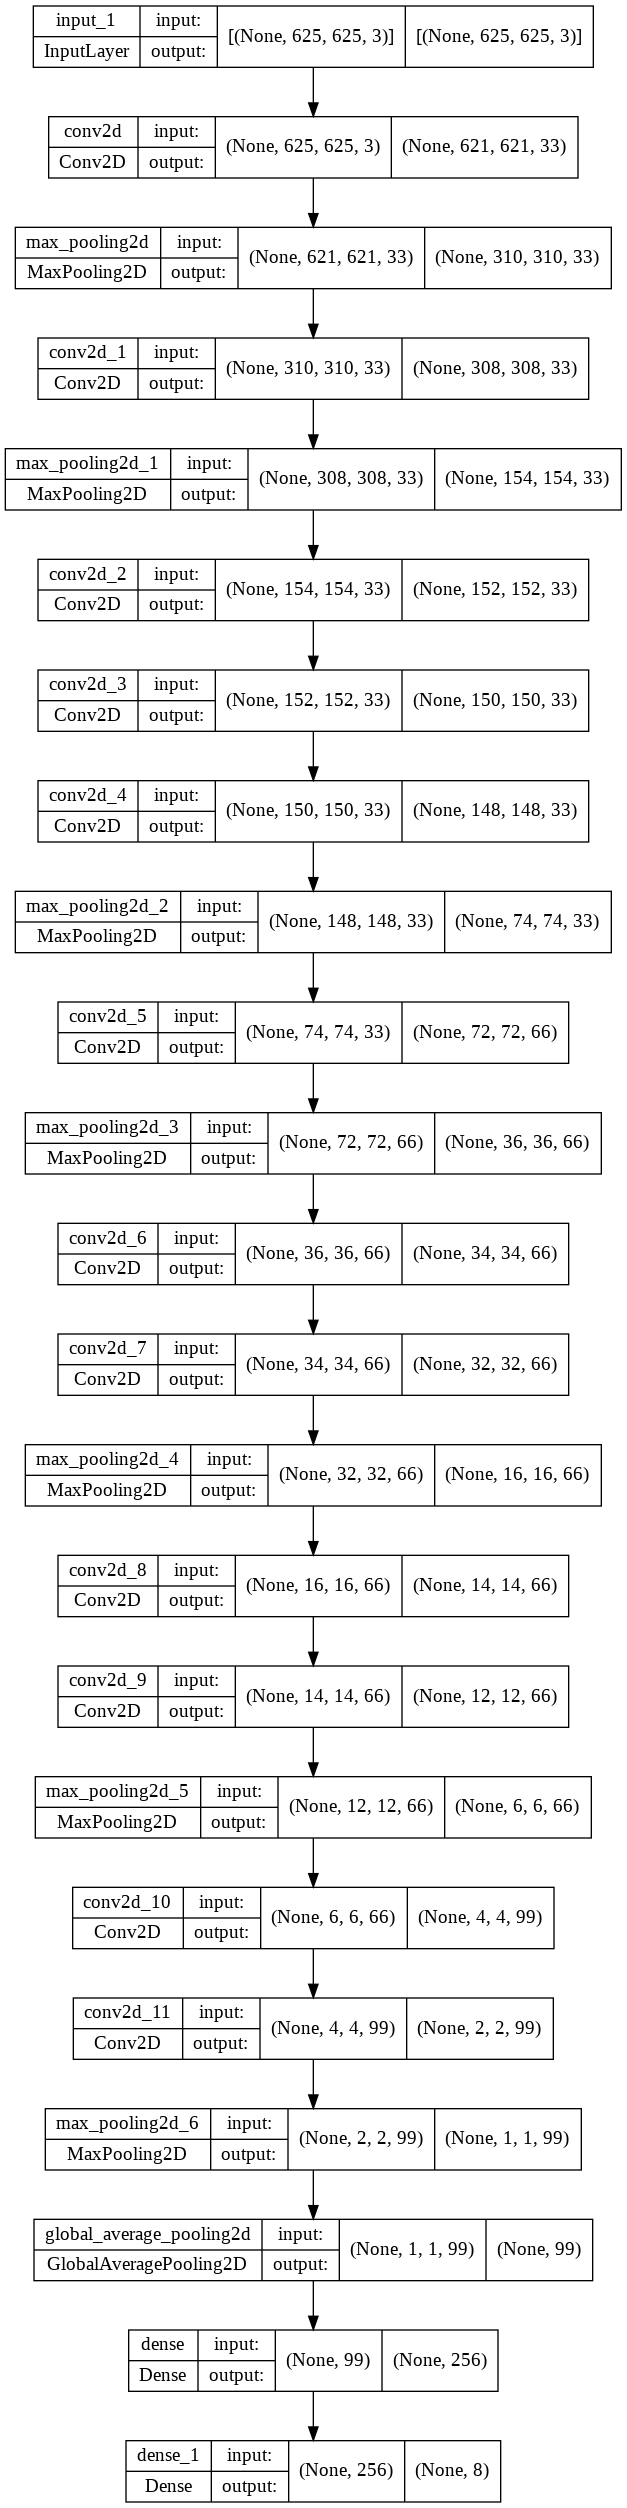

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
if os.path.exists('detect.h5'):
  print('load pretrain model')
  model = tf.keras.models.load_model('detect.h5')
  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-6))

load pretrain model


In [30]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
131/131 [==============================] - 165s 1s/step - loss: 3.9331e-05 - val_loss: 4.7941e-04
Epoch 2/10
131/131 [==============================] - 165s 1s/step - loss: 3.9330e-05 - val_loss: 4.7934e-04
Epoch 3/10
131/131 [==============================] - 165s 1s/step - loss: 3.9331e-05 - val_loss: 4.7934e-04
Epoch 4/10
131/131 [==============================] - 165s 1s/step - loss: 3.9319e-05 - val_loss: 4.7956e-04
Epoch 5/10
131/131 [==============================] - 165s 1s/step - loss: 3.9319e-05 - val_loss: 4.7932e-04
Epoch 6/10
131/131 [==============================] - 165s 1s/step - loss: 3.9320e-05 - val_loss: 4.7930e-04
Epoch 7/10
131/131 [==============================] - 165s 1s/step - loss: 3.9305e-05 - val_loss: 4.7929e-04
Epoch 8/10
131/131 [==============================] - 164s 1s/step - loss: 3.9320e-05 - val_loss: 4.7935e-04
Epoch 9/10
131/131 [==============================] - 164s 1s/step - loss: 3.9306e-05 - val_loss: 4.7949e-04
Epoch 10/10
131/131

### 检验训练拟合度和验证集情况

训练拟合度


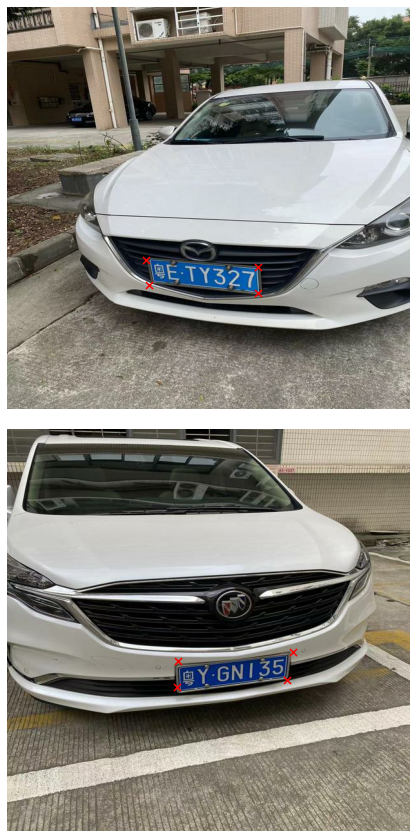

模型预测


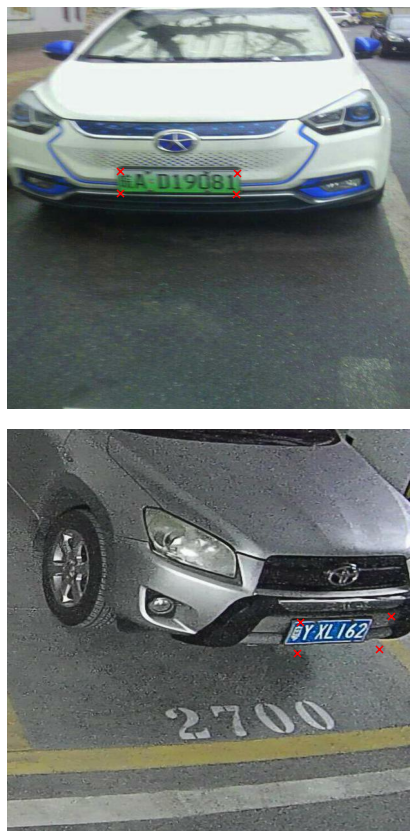

In [31]:
print("训练拟合度")
sample_image = np.array([
  load_sample('./resized/train/粤ETY327/粤ETY327.jpg'), 
  load_sample('./resized/train/粤YGNI35/粤YGNI35.jpg')
])
visualize_keypoints(sample_image, model.predict(sample_image))

print("模型预测")
sample_image = np.array([
  load_sample('./resized/validation/5637/5637.jpg'), 
  load_sample('./resized/validation/粤YXLI62/粤YXLI62.jpg')
])
visualize_keypoints(sample_image, model.predict(sample_image))

### 调整学习率

In [26]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-7))

### 保存模型

In [32]:
model.save('detect150.h5')